In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import deepchem as dc
import pandas as pd
import pickle
import numpy as np
import warnings

from utils import *
warnings.filterwarnings('ignore')

def runExp(params, smiles, expt, feat, part):#partition (train, test, val)
    smiles = partition(smiles, part)
    expt = partition(expt, part)
    feat = partition(feat, part)

    featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
    
    train = dc.data.NumpyDataset(X=featurizer.featurize(smiles[0]), y=np.array(expt[0]-feat[0]).transpose())

    model = dc.models.GraphConvModel(n_tasks=1, graph_conv_layers=params['graph_conv_layers'], mode='regression', dropout=params['dropout'], batch_normalize=params['batch_normalize'], batch_size=params['batch_size'], dense_layer_size=params['dense_layer_size'])
    model.fit(train, nb_epoch=params['epochs'])

    p = ()
    for i in range(len(part)):
        p += (np.array(model.predict_on_batch(featurizer.featurize(smiles[i])).flatten()),)

    p_true = {'test' : list(expt[1]), 'train' : list(expt[0])}
    p_phy = {'test' : list(feat[1]), 'train' : list(feat[0])}
    p_corr = {'test' : list(p[1]) + feat[1], 'train' : list(p[0] + feat[0])}

    if(len(part) > 2):
        p_true['valid'] = list(expt[2])
        p_phy['valid'] = list(feat[2])
        p_corr['valid'] = list(p[2]+feat[2])

    return p_true, p_phy, p_corr

def kfold(params, b = None, val = None):
    np.random.seed(10)
    k = params['kfold']
    if(type(b) == type(None)):
        b = psuedoScramble(expt, bins=int(len(expt)/k))

    folds = []
    for i in range(k):
        folds.append(b[i::k])
    
    p_true = []
    p_phy = []
    p_corr = []
    stats = []
    for i in range(k):
        part = (np.hstack(tuple(folds[:i])+tuple(folds[(i+1):])), folds[i])#train, test, val
        
        #if(type(val) != type(None)):
        #    part += (val,)
        #    print("(kth, train, test, val)  :  ", (i, len(part[0]), len(part[1]), len(part[2])))
        #else:
        #    print("(kth, train, test)  :  ", (i, len(part[0]), len(part[1])))
        #print(" " + str(i)),

        pt, pp, pc = runExp(params, smiles, expt, feats[params['feat']], part)

        p_true.append(pt)
        p_phy.append(pp)
        p_corr.append(pc)
       

        if(type(val) != type(None)):
             stats.append({
                'phy_rmsd' :     {'test' : rmsd(        pt['test'], pp['test']), 'train' : rmsd(        pt['train'], pp['train']), 'valid' : rmsd(       pt['valid'], pp['valid'])},
                'ml_rmsd'  :     {'test' : rmsd(        pt['test'], pc['test']), 'train' : rmsd(        pt['train'], pc['train']), 'valid' : rmsd(       pt['valid'], pc['valid'])},
                'phy_md' :       {'test' : md(          pt['test'], pp['test']), 'train' : md(          pt['train'], pp['train']), 'valid' : md(         pt['valid'], pp['valid'])},
                'ml_md'  :       {'test' : md(          pt['test'], pc['test']), 'train' : md(          pt['train'], pc['train']), 'valid' : md(         pt['valid'], pc['valid'])},
                'phy_out_rmsd' : {'test' : ormsd(0.05,  pt['test'], pp['test']), 'train' : ormsd(0.05,  pt['train'], pp['train']), 'valid' : ormsd(0.05, pt['valid'], pp['valid'])},
                'ml_out_rmsd'  : {'test' : ormsd(0.05,  pt['test'], pc['test']), 'train' : ormsd(0.05,  pt['train'], pc['train']), 'valid' : ormsd(0.05, pt['valid'], pc['valid'])}
            })#
        else:
             stats.append({
                'phy_rmsd' :     {'test' : rmsd(        pt['test'], pp['test']), 'train' : rmsd(        pt['train'], pp['train'])},
                'ml_rmsd'  :     {'test' : rmsd(        pt['test'], pc['test']), 'train' : rmsd(        pt['train'], pc['train'])},
                'phy_md' :       {'test' : md(          pt['test'], pp['test']), 'train' : md(          pt['train'], pp['train'])},
                'ml_md'  :       {'test' : md(          pt['test'], pc['test']), 'train' : md(          pt['train'], pc['train'])},
                'phy_out_rmsd' : {'test' : ormsd(0.05,  pt['test'], pp['test']), 'train' : ormsd(0.05,  pt['train'], pp['train'])},
                'ml_out_rmsd'  : {'test' : ormsd(0.05,  pt['test'], pc['test']), 'train' : ormsd(0.05,  pt['train'], pc['train'])}
            })#

    return p_true, p_phy, p_corr, stats

In [6]:
freeSolve = pickle.load(open('dicts/consol.pickle', 'rb')) # FreeSolve Database

expt, tip, smiles, gbn, igb, asc, nul = [], [], [], [], [], [], []
for i in freeSolve.keys():
    expt.append(freeSolve[i]['expt'])
    smiles.append(freeSolve[i]['smiles'])
    #
    tip.append(freeSolve[i]['calc'])
    gbn.append(freeSolve[i]['gbnsr6'])
    igb.append(freeSolve[i]['igb5'])
    asc.append(freeSolve[i]['asc'])
    nul.append(0)
    feats = {'tip3p' : tip, 'gbnsr6' : gbn, 'igb5' : igb, 'asc' : asc, 'null' : nul}

In [46]:
np.random.seed(10)
b = list(psuedoScramble(expt, bins=int(len(expt)/10)))
val = []
for i in range(len(b)//8):
    #j = np.random.randint(0, len(b))
    j = i*7
    val.append(b.pop(j))

# dl_arr = np.array(-3+10*np.power(3, np.arange(0, 4, 1)), int)
# drop_arr = np.arange(0, 1, 0.1)
cl_arr = np.arange(2, 123,10)
# cl_arr = np.array([32,64,100])
# dl_arr = np.array([10,27,100,250])
# dl_arr = np.array([27,40])
cl_arr

array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122])

In [50]:
%%time
f = 0
dropout = 0.6
k = 10
iterations = 1
val_means = []
train_means = []
val_stds = []
train_stds = []
error = 1#0.47 for 20 fold
print('dropout =',dropout)
warnings.filterwarnings('ignore')
for cl in cl_arr:
    # # for cl in cl_arr:
    #     # for dl in dl_arr:    
    # #params = {'graph_conv_layers' : [64, 64], 'epochs' : 500, 'dropout' : drop, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'null', 'kfold' : 10, 'dense_layer_size' : dl}
    params = {'graph_conv_layers' : [cl, cl], 'epochs' : 500, 'dropout' : dropout, 
              'batch_normalize' : False,'batch_size'  : 100, 'feat' : 'tip3p', 
              'kfold' : k, 'dense_layer_size' : 27}
    #
    p_true = []
    p_phy = []
    p_corr = []
    stats = []
    #print(dl, ", ", drop)
    for i in range(iterations):
        #print((cl, i))
        pt, pp, pc, s = kfold(params,b)
        p_true += pt
        p_phy += pp
        p_corr += pc
        stats += s
    # d = {'true' : p_true, 'phy' : p_phy, 'corr' : p_corr, 'stats' : stats, 'params' : params}
    p_test, p_train, ml_test, ml_train = [],[],[],[]
    for i in range(k*iterations):
        p_test.append(stats[i]['phy_rmsd']['test'])
        p_train.append(stats[i]['phy_rmsd']['train'])
        ml_test.append(stats[i]['ml_rmsd']['test'])
        ml_train.append(stats[i]['ml_rmsd']['train'])
    if(f==0):
        f+=1
        print('physics model: val',np.round(np.mean(p_test),3),'±',np.round(error*np.std(p_test),3),
              'train',np.round(np.mean(p_train),3),'±',np.round(error*np.std(p_train),3))
    print(cl,cl)
    val_means.append(np.mean(ml_test))
    train_means.append(np.mean(ml_train))
    val_stds.append(np.std(ml_test))
    train_stds.append(np.std(ml_test))
    print('physics + ml: val',np.round(np.mean(ml_test),3),'±',np.round(error*np.std(ml_test),3),
              'train',np.round(np.mean(ml_train),3),'±',np.round(error*np.std(ml_train),3))
val_means_6 = val_means
val_stds_6 = val_stds
train_means_6 = train_means
train_stds_6 = train_stds

dropout = 0.6
physics model: val 1.537 ± 0.238 train 1.556 ± 0.029
2 2
physics + ml: val 1.45 ± 0.232 train 1.419 ± 0.125
12 12
physics + ml: val 1.41 ± 0.313 train 1.327 ± 0.157
22 22
physics + ml: val 1.267 ± 0.22 train 1.16 ± 0.079
32 32
physics + ml: val 1.184 ± 0.204 train 1.04 ± 0.051
42 42
physics + ml: val 1.166 ± 0.198 train 0.969 ± 0.053
52 52
physics + ml: val 1.102 ± 0.181 train 0.898 ± 0.074
62 62
physics + ml: val 1.084 ± 0.197 train 0.851 ± 0.044
72 72
physics + ml: val 1.065 ± 0.151 train 0.813 ± 0.058
82 82
physics + ml: val 1.017 ± 0.156 train 0.807 ± 0.043
92 92
physics + ml: val 0.981 ± 0.153 train 0.76 ± 0.031
102 102
physics + ml: val 1.0 ± 0.126 train 0.739 ± 0.034
112 112
physics + ml: val 1.014 ± 0.151 train 0.745 ± 0.051
122 122
physics + ml: val 1.001 ± 0.178 train 0.734 ± 0.039
CPU times: user 1h 44min 49s, sys: 13min 17s, total: 1h 58min 6s
Wall time: 42min 2s


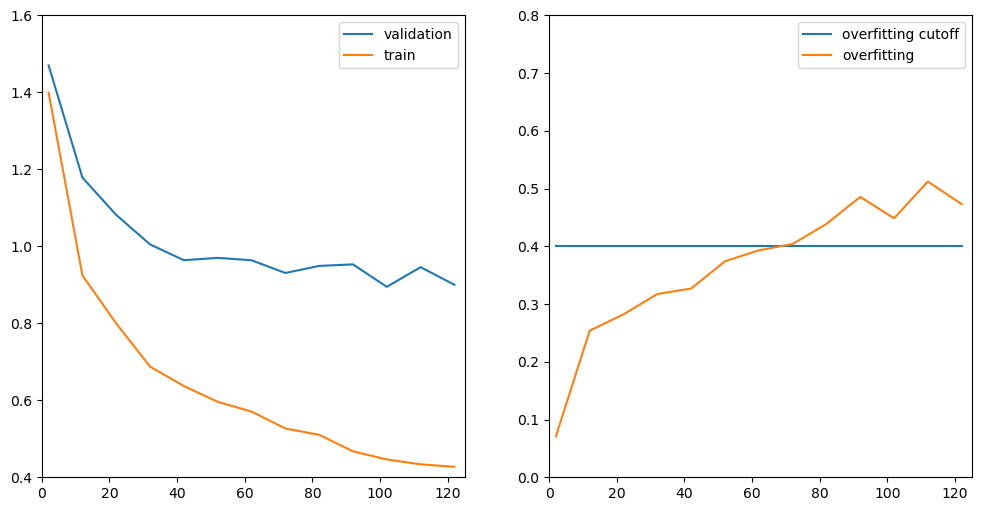

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.xlim([0,125])
plt.ylim([0.4, 1.6])
plt.plot(cl_arr,val_means_4, label = "validation")
plt.plot(cl_arr, train_means_4, label = "train")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlim([0,125])
plt.ylim([0, 0.8])
plt.plot(cl_arr, np.full(len(cl_arr),0.4),label='overfitting cutoff')
plt.plot(cl_arr, (np.array(val_means_4) - np.array(train_means_4)), label='overfitting')
plt.legend(loc='upper right')

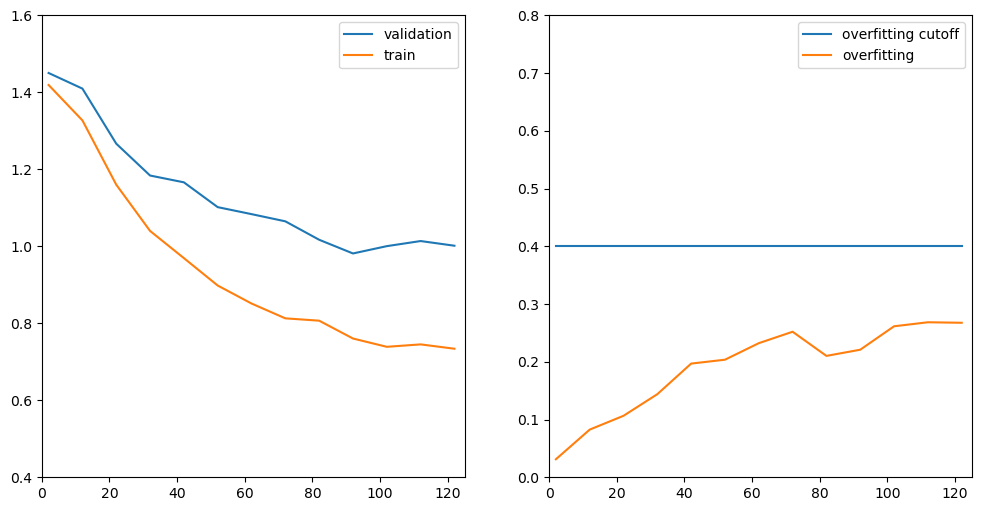

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.xlim([0,125])
plt.ylim([0.4, 1.6])
plt.plot(cl_arr,val_means_6, label = "validation")
plt.plot(cl_arr, train_means_6, label = "train")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlim([0,125])
plt.ylim([0, 0.8])
plt.plot(cl_arr, np.full(len(cl_arr),0.4),label='overfitting cutoff')
plt.plot(cl_arr, (np.array(val_means_6) - np.array(train_means_6)), label='overfitting')
plt.legend(loc='upper right')

In [ ]:
# dropout = 0.4
# physics model: val 1.537 ± 0.172 train 1.556 ± 0.021
# 27 32 32 32
# physics + ml: val 1.068 ± 0.153 train 0.815 ± 0.031
# 27 100 100 100
# physics + ml: val 1.025 ± 0.096 train 0.802 ± 0.053
# CPU times: user 22min 24s, sys: 3min 32s, total: 25min 56s
# Wall time: 7min 44s

# dropout = 0.3
# physics model: val 1.494 ± 0.121 train 1.558 ± 0.006
# 27 32 32 32
# physics + ml: val 0.878 ± 0.108 train 0.623 ± 0.02
# 27 100 100 100
# physics + ml: val 0.926 ± 0.07 train 0.542 ± 0.016
# CPU times: user 45min 35s, sys: 7min 2s, total: 52min 38s
# Wall time: 16min 8s

# dropout = 0.2
# physics model: val 1.494 ± 0.121 train 1.558 ± 0.006
# 27 32 32 32
# physics + ml: val 0.922 ± 0.094 train 0.464 ± 0.011
# 27 64 64 64
# physics + ml: val 0.924 ± 0.077 train 0.347 ± 0.008
# CPU times: user 36min 20s, sys: 5min 49s, total: 42min 9s
# Wall time: 15min

# dropout = 0.25
# physics model: val 1.494 ± 0.121 train 1.558 ± 0.006
# 27 32 32 32
# physics + ml: val 0.887 ± 0.081 train 0.536 ± 0.015
# 27 64 64 64
# physics + ml: val 0.927 ± 0.084 train 0.442 ± 0.017
# CPU times: user 36min 22s, sys: 5min 48s, total: 42min 11s
# Wall time: 15min 1s

In [ ]:
# only train data, dropout = 0.4
# 10 32 32
# physics model: val 1.5373615161874685 train 1.5557903132714035
# physics + ml: val 1.0292302154825053 train 0.7232153447402927
# 27 32 32
# physics + ml: val 0.9770040729085029 train 0.6830996619064614
# 100 32 32
# physics + ml: val 0.9955521910451337 train 0.6686805652409489
# 250 32 32
# physics + ml: val 1.0273934889548 train 0.7128308872430708
# 10 100 100
# physics + ml: val 0.9823271197535532 train 0.628425052817039
# 27 100 100
# physics + ml: val 0.9468407868655351 train 0.47150221142783194
# 100 100 100
# physics + ml: val 0.9589371697731199 train 0.446734255997206
# 250 100 100
# physics + ml: val 0.9838971337842111 train 0.5376571480372064
# 10 150 150
# physics + ml: val 0.978652660187189 train 0.601892975699843
# 27 150 150
# physics + ml: val 0.8889404230829708 train 0.39178779955900805
# 100 150 150
# physics + ml: val 0.9487593366582571 train 0.3725260330757646
# 250 150 150
# physics + ml: val 0.9572514091810124 train 0.3935592280465501
# CPU times: user 2h 13min 48s, sys: 16min 54s, total: 2h 30min 43s
# Wall time: 42min 47s



# only train data, dropout = 0.6
# 10 32 32
# physics model: val 1.5373615161874685 train 1.5557903132714035
# physics + ml: val 1.1648836102072004 train 1.0605964244213688
# 27 32 32
# physics + ml: val 1.1838357798443537 train 1.0474263047146186
# 100 32 32
# physics + ml: val 1.230646581753589 train 1.0906247483563658
# 250 32 32
# physics + ml: val 1.1850971841069164 train 1.049899431198495
# 10 100 100
# physics + ml: val 1.106212644249468 train 0.9365003773197846
# 27 100 100
# physics + ml: val 1.0238470377101863 train 0.7582033228488252
# 100 100 100
# physics + ml: val 1.0408522630044363 train 0.7589183494020463
# 250 100 100
# physics + ml: val 1.0959363315344226 train 0.8290420129149603
# 10 150 150
# physics + ml: val 1.138058458563442 train 0.9551620400955194
# 27 150 150
# physics + ml: val 1.0237552979681737 train 0.7393444135386055
# 100 150 150
# physics + ml: val 0.9771859208643946 train 0.6659726260221743
# 250 150 150
# physics + ml: val 1.0318967247922857 train 0.7213781671923698
# CPU times: user 1h 47min 25s, sys: 12min 52s, total: 2h 18s
# Wall time: 31min 23s

# full data, dropout = 0.6
# 13 32 32
# physics model: val 1.5167247487088094 train 1.5411564817428087
# physics + ml: val 1.1491565582148449 train 0.9963360442688078
# 27 32 32
# physics + ml: val 1.1670582130616194 train 1.0082202748595521
# 60 32 32
# physics + ml: val 1.1680509592741912 train 1.0422767544150084
# 141 32 32
# physics + ml: val 1.2004684820167708 train 1.0842672930679593
# 334 32 32
# physics + ml: val 1.1217314384796173 train 1.0034599428573205
# 799 32 32
# physics + ml: val 1.140226747333509 train 0.962680588881638
# 13 100 100
# physics + ml: val 1.039503305344034 train 0.8418692906132064
# 27 100 100
# physics + ml: val 0.9795314851007969 train 0.7595508142588816
# 60 100 100
# physics + ml: val 0.9708371045867015 train 0.7240939619618202
# 141 100 100
# physics + ml: val 0.9937531691319433 train 0.7685223931197264
# 334 100 100
# physics + ml: val 0.9801231707766705 train 0.754897005471198
# 799 100 100
# physics + ml: val 1.0109858172310806 train 0.7761294344749184
# 13 150 150
# physics + ml: val 1.0126766357301291 train 0.847946912147132
# 27 150 150
# physics + ml: val 0.9392793180475838 train 0.7224666620389
# 60 150 150
# physics + ml: val 0.9256472986160038 train 0.6598254740694074
# 141 150 150
# physics + ml: val 0.9563205734422228 train 0.6731727863788801
# 334 150 150
# physics + ml: val 0.9826366472129404 train 0.6712038464043742
# 799 150 150
# physics + ml: val 0.9709365129249348 train 0.6680712580395424
# CPU times: user 4h 1min 16s, sys: 26min 41s, total: 4h 27min 58s
# Wall time: 1h 4min 25s

In [ ]:


# dropout = 0.6
# 32
# physics model: test 1.5209077440232828 train 1.5411694735603756
# physics + ml: test 1.162570568215586 train 1.033796780454706
# 70
# physics model: test 1.5249864156765092 train 1.5413035324411175
# physics + ml: test 1.0252703946021584 train 0.8107631718365695
# 108
# physics model: test 1.5124502912598086 train 1.541114760392822
# physics + ml: test 0.9765001654103165 train 0.752452309641396
# 146
# physics model: test 1.52515676164307 train 1.5412979829688769
# physics + ml: test 0.9590083250033826 train 0.7246334859350201
# 184
# physics model: test 1.5243104227490312 train 1.5412881732638302
# physics + ml: test 1.0092899551992809 train 0.7187569720230159
# CPU times: user 54min 46s, sys: 6min 39s, total: 1h 1min 25s
# Wall time: 17min 8s

# 32 32
# physics model: test 1.5289097866312844 train 1.5413644903415518
# physics + ml: test 1.1787202181089071 train 1.040802779310058
# 32 80
# physics model: test 1.5291270172412832 train 1.5413465207551256
# physics + ml: test 1.0706931991380357 train 0.8763767988031675
# 32 120
# physics model: test 1.5240260321755326 train 1.5412902254832144
# physics + ml: test 1.0248715025417428 train 0.8117060020580297
# 80 32
# physics model: test 1.5256977838554602 train 1.5413151340126823
# physics + ml: test 1.0580371158904616 train 0.8781923000530032
# 80 80
# physics model: test 1.5149648814113479 train 1.5411544309895768
# physics + ml: test 1.0503167468393826 train 0.7885529574949306
# 80 120
# physics model: test 1.5309996128834569 train 1.5413661973661927
# physics + ml: test 0.9680893025712176 train 0.7312615169467275
# 120 32
# physics model: test 1.514888655228146 train 1.5410937264077758
# physics + ml: test 1.056260970382536 train 0.8466634590404654
# 120 80
# physics model: test 1.5308236535256277 train 1.5413745050978487
# physics + ml: test 0.9869284581175395 train 0.7628552024753095
# 120 120
# physics model: test 1.5271327557173924 train 1.5413326725284109
# physics + ml: test 0.9972211202722823 train 0.751790977756478
# CPU times: user 1h 13min 5s, sys: 10min 13s, total: 1h 23min 18s
# Wall time: 27min 22s